# A collection of examples showing how to carry out computations of 
# Protein-Ligand  Interaction Fingerprits, IFPs,  using MD-IFP tools but without using a trajectory object.

# IFPs can be generated for 

## (i) a PDB structure
## (ii) a single MD trajectory

    1. Computing interaction fingerprints (IFP) for
        -- a single structure prepared for MD simulations (HSP90; PDB ID 6EI5, dcd format)
        -- PDB structure
    2. Visualizing protein residues that are involved in protein-ligand interactions, including water-bridges
  
  

### Input data required:
    MD trajectory file of a complex
    pdb file of a complex (for example, generated from the first frame)
    pdb and mol2 file of a ligand separately 
    Data can be downloaded from Zenodo  https://zenodo.org/record/3981155#.XzQEUCgzaUk   - version 3.1
    
        Data directory must look like this (otherwise you have to edit file location in the code)
    
    Data
    ├── 2YKI
    │   ├── 2YKI.pse
    │   ├── 2yki.pdb
    │   ├── 2yki_MOE.pdb
    │   ├── ligand_2yki_MOE.mol2
    │   └── ligand_2yki_MOE.pdb
    └── 6EI5
    │   ├── INH.pdb
    │   ├── amber2namd2.dcd
    │   ├── moe.mol2
    │   ├── ref-min.pdb
    │   └── ref.prmtop
   


    
    
### Packages required:
    numpy
    matplotlib
    MDAnalysis v. 20.1 or above
    pandas
    seaborn
    RDkit
    nglview
    code is written on Python 3.x and tested on the version 3.7



### v 1.0
    06.06.2020
    Copyright (c) 2020
    Released under the EUPL Licence, v1.2 or any higher version
    
### Authors: Daria Kokh & Fabian Ormersbach 
    Daria.Kokh@h-its.org
    Heidelberg Institute of Theoretical Studies (HITS, www.h-its.org)
    Schloss-Wolfsbrunnenweg 35
    69118 Heidelberg, Germany
    
    

##  Application example 

    Heat Shock Protein 90 (HSP90)

Import all of the required packages and scripts

In [1]:
import glob, os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nglview as nv
import MDAnalysis as mda
import warnings
from rdkit import Chem, RDConfig
from rdkit.Chem.rdMolChemicalFeatures import MolChemicalFeatureFactory
from Scripts.IFP_generation import *
from Scripts.Trajectories import *
#from Scripts.Complex_structure import *
#from Scripts.Clustering import *

%load_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")

_ColormakerRegistry()

RDKit WARNING: [09:00:26] Enabling RDKit 2019.09.3 jupyter extensions


## 1. Generation IFPs for a single HSP90 structure (PDB ID 6EI5) prepared for MD simulations 
### 1.1 find chemical properties of the ligand using RDKit 

Before we start with the IFP-Analysis we first need to extract the chemical information of the ligand.

In [2]:
# Define the path to the Ligand data, pdb file and mol2 file are needed
ligand_pdb = "Data/6EI5//INH.pdb"
ligand_mol2 = "Data/6EI5//moe.mol2"

# Get the atom names of the ligand
with open(ligand_pdb, 'r') as fasta_file: #Does ff stand for fasta file? 
    list_labels = [line.split()[2] for line in fasta_file.readlines() if line.split()[0]=='ATOM']

# Get the ligand features using RDKit feature factory
mol = Chem.rdmolfiles.MolFromMol2File(ligand_mol2, removeHs=False)
factory_name = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
factory = Chem.ChemicalFeatures.BuildFeatureFactory(factory_name)
features = factory.GetFeaturesForMol(mol)

# Create dictionary that maps Atoms to their features
properties = {feature.GetFamily():[] for feature in features}
for feature in features:
    current_atoms = [list_labels[atom_id] for atom_id in list(feature.GetAtomIds())]
    for atom in current_atoms:
        properties[feature.GetFamily()].append(atom)
print("Molecular properties of the compound:\n")
print(properties)
# Additionally we need to load our protein/ligand complex into a MDAnalysis universe
ref_pdb = 'Data/6EI5/ref-min.pdb'
u = mda.Universe(ref_pdb)

Molecular properties of the compound:

{'Donor': ['N3', 'N14', 'N30'], 'Acceptor': ['O4', 'N8', 'N10'], 'PosIonizable': ['N30'], 'Aromatic': ['C1', 'C7', 'C11', 'C12', 'C9', 'C6', 'C1', 'C6', 'N10', 'C13', 'N8', 'C5', 'C15', 'C24', 'C25', 'C26', 'C27', 'C28', 'C18', 'C23', 'C22', 'C21', 'C20', 'C19'], 'Hydrophobe': ['C1', 'C7', 'C9', 'C11', 'C12', 'C15', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28'], 'LumpedHydrophobe': ['C1', 'C7', 'C11', 'C12', 'C9', 'C6', 'C15', 'C24', 'C25', 'C26', 'C27', 'C28', 'C18', 'C23', 'C22', 'C21', 'C20', 'C19']}


### 1.2 Generate PL IFPs 
Now that we have all the chemical information for our ligand, we can start the actual IFP analysis.  
The possible interactions with their corresponding abbreviations are shown in the table below.  
  
| Abbreviation |    Type of interaction   |
|:---------------|:---------------------------|
|   HY  | Hydrophobic |
|  IP  |       Salt bridge (positive charge) |
|  IN  |       Salt bridge (negative charge) |
|  AR  |   $\pi$-stacking  |
|    |  Cation-$\pi$  |
|    |  $\pi$-Cation  |
|    |  $\pi$-Amide  |
|  HL  |  Halogen-$\pi$  |
|    |  Halogen-carboxyl  |
|    |  Halogen-Amide  |
|    |  Halogen-Sulfur  |
|  HD  |  Hydrogen-bond donor  |
|  HA  |  Hydrogen-bond acceptor  |
|  WB  |  Water bridge  |

For this we use the IFP and table_combine functions contained in the IFP_generation script.\
The IFP function takes a variety of inputs.\
We need to supply our universe,  the ligand residue name and the properties of our ligand and set RE to false. The other settings we'll leave on the default for now.\
The IFP function returns three data frames: all IFPs properties except hydrogen bonds, hydrogen bonds only, and a waterbridges.
Then we can combine all three tables in one

In [3]:
df_prop,df_HB,df_WB = IFP(u,"INH",properties,RE=False)
df_prop_complete = table_combine(df_HB,df_WB,df_prop,"INH")

Start HB analysis 09:00:31.010103
Start WB analysis 09:00:31.453852
Start collecting IFPs:  09:00:33.115897
Start building IFP table:  09:00:38.396874
IFP database is ready  09:00:38.400871


This is the complete IFP database.\
It contains Waterbridges between the ligand and THR168, ASP77 and GLY81.\
Hydrogen bonds and aromatic contact with the ligand are constituted with ASP77/168, and PHE122/TRP146 respectively.

In [4]:
df_prop_complete

,time,WB_LEU32,WB_SER36,HY_ALA39,HA_ASP77,WB_ASP77,HY_ILE80,WB_GLY81,HY_MET82,HY_LEU91,HY_ILE94,AR_PHE122,HY_PHE122,AR_TRP146,HD_THR168,WAT
0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4


### 1.4 Visualization of protein residues involved in the PL interactions
For the visualization in jp notebook we'll use NGLWidget.\
Let's first look at all residues participating in protein-ligand water bridges and H-bonds (taken from df_HB and df_WB).

In [5]:
water_bridges = df_WB[df_WB.sele1_resnm == "WAT"].sele1_resid.values
view = nv.NGLWidget()

# We only want to see the protein and the ligand
u_reduced = u.select_atoms('protein or (resname INH WAT)')
w=nv.show_mdanalysis(u_reduced)
residues = "32 36  77 81 " + ''.join([" "+ str(w) for w in water_bridges])
w.add_licorice(residues)
w

NGLWidget()

In [6]:
view = nv.NGLWidget()
u_reduced = u.select_atoms('protein or (resname INH )')
w = nv.show_mdanalysis(u_reduced)

residues = ''.join([' ' + str(ifp[6:]) for ifp in df_prop_complete.columns.tolist() 
                    if (ifp[:2] == 'AR')])
print('Showing aromatic residues', residues)
w.add_licorice(residues)
w

Showing aromatic residues  122 146


NGLWidget()

## 2. Generation of PL IFPs for a single MD trajectory
### 2.1 Read a trajectory, compute PL IFPs and show results
This time we'll calculate the IFPs not for a static situation, but over a trajectory. The procedure stays mainly the same as the above, with a few tweaks.

Start HB analysis 09:01:04.490783
Start WB analysis 09:01:07.829875
Start collecting IFPs:  09:01:35.889706
Start building IFP table:  09:03:28.889941
IFP database is ready  09:03:28.940912


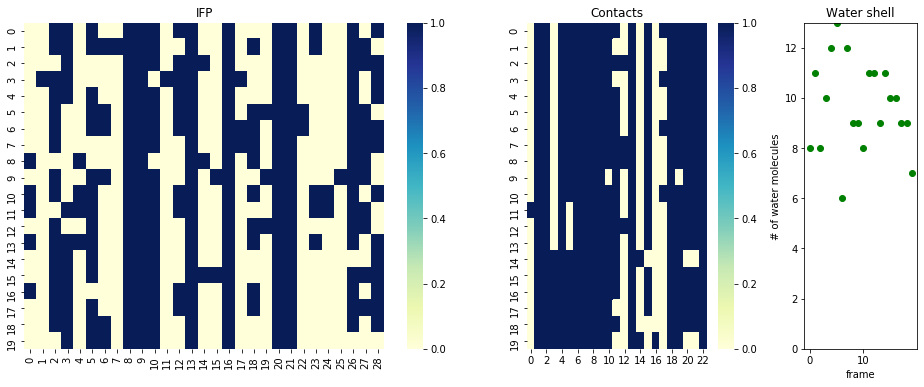

In [7]:
# Set the file paths for all of the needed data
ref_pdb = "Data/6EI5/ref-min.pdb"
ligand_pdb = "Data/6EI5//INH.pdb"
ligand_mol2 = "Data/6EI5//moe.mol2"
traj = "Data/6EI5/amber2namd2.dcd"

# Initialize the MDAnalysis Universes (static and with trajectory) and calculate the radius of gyration 
ref = mda.Universe(ref_pdb)
Rgyr_t0 = ref.select_atoms("protein").radius_of_gyration()

u = mda.Universe(ref_pdb,traj) 
u_length = len(u.trajectory)

# Load part of the trajectory in the memory
u_reduced = u.select_atoms('protein or (resname INH WAT)')    
stepsize = 50
u_mem = mda.Merge(u_reduced).load_new(AnalysisFromFunction(
            lambda ag: ag.positions.copy(), u_reduced).run(
                start=0,stop=-1,step=stepsize).results,format=MemoryReader)

# Bring the trajectory into the right format
# One can save selected snapshots in the pdb format
save_pdb = False 

RMSDl = []
RMSDp = []
for i in range(0,len(u_mem.trajectory),1):
    u_mem.trajectory[i]  
    u_mem.dimensions = u.dimensions
    
    # Wrap all atoms back to the box, use radius of gyration for checking whether the procedure was successful
    Rgyr = pbc(u_mem,Rgyr_t0)

    # Calculate Root-mean-square deviation
    rmsd = superimpose_traj(ref,u_mem,["protein","resname INH"])
    RMSDp.append(rmsd[0])
    RMSDl.append(rmsd[1])
    
#    print(i,"RMSD (protein , ligand):",rmsd,"traj length:",u_length)
    
    if save_pdb == True:
        all_write = u.select_atoms("all")
        all_write.write("/hits/fast/mcm/kokhda/TMP/"+"/namd_protein-"+str(i)+".pdb")

# Compute IFP:
# parameters used: 
#  WB_analysis=True  - find water-mediated protein-ligand contacts; 
#  RE = False - don't store unspecific prorein-ligand contacts
df_prop,df_HB,df_WB = IFP(u_mem, "INH", properties, WB_analysis=True, RE=True, Lipids=[])

# Build IFP table
df_prop_complete = table_combine(df_HB, df_WB, df_prop, "INH")

# Plot IFPs
Plot_IFP(df_prop_complete, contact_collection=None)


### Explanation for the plots:  
The first plot shows the devlopment of detected IFPs over the time of the trajetorie.  
The second plot shows all contacts between ligand and protein over the time of the trajectorie.  
The third plot shows the amount of molecules participating in the water shell of the ligand.

Additionally, we can plot the variation of RMSD for the protein and ligand heavy atoms (relative to the reference structure ref_pdb):

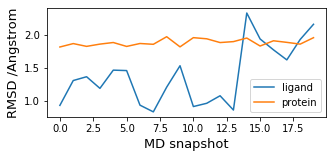

In [8]:
fig = plt.figure(figsize = (5,2),facecolor='w')
plt.plot(RMSDl,label="ligand")
plt.plot(RMSDp,label="protein")
plt.xlabel("MD snapshot", fontsize=13)
plt.ylabel("RMSD /Angstrom", fontsize=13)
plt.legend()
plt.show()

### 2.2 PL IFP table
Now we can take a look at the calculated tables.\
First we will look at water molecules participating in protein-ligand water bridges.
Not all frames are included in this table - only those where at least one water bridge found
"sele1*" is either ligand or water molecule that mediate ligand-protein interaction
"sele2*" is either protein or water

In [9]:
df_WB

,time,sele1_index,sele2_index,sele1_resnm,sele1_resid,sele1_atom,sele2_resnm,sele2_resid,sele2_atom,distance,angle
7,0.0,3326,1248,WAT,267,H2,ASP,77,OD1,1.700639,163.627926
8,0.0,3326,1249,WAT,267,H2,ASP,77,OD2,3.167911,127.500696
13,0.0,19784,574,WAT,5753,H2,ASN,35,OD1,3.093062,115.841596
3,0.0,3270,3325,INH,208,N10,WAT,267,H1,2.014190,167.031486
4,0.0,3264,19783,INH,208,O4,WAT,5753,H1,2.121748,148.085671
...,...,...,...,...,...,...,...,...,...,...,...
129,18.0,3264,4684,INH,208,O4,WAT,720,H1,2.410882,146.094608
545,18.0,3315,577,WAT,264,O,ASN,35,HD22,2.108906,168.484768
559,19.0,3326,1248,WAT,267,H2,ASP,77,OD1,1.729018,161.655372
560,19.0,3326,1249,WAT,267,H2,ASP,77,OD2,2.569712,137.049037


Then we can open the table with all hydrogen bonds

In [10]:
df_HB

,time,donor_index,acceptor_index,donor_resnm,donor_resid,donor_atom,acceptor_resnm,acceptor_resid,acceptor_atom,distance,angle
0,0.0,3295,587,INH,208,H141,SER,36,OG,3.182179,103.037945
1,0.0,3296,587,INH,208,H142,SER,36,OG,3.205784,101.580293
2,0.0,3296,1248,INH,208,H142,ASP,77,OD1,3.258567,163.623818
3,0.0,3296,1249,INH,208,H142,ASP,77,OD2,1.803541,154.625633
4,0.0,2568,3270,THR,168,HG1,INH,208,N10,3.038169,115.269321
5,1.0,3295,587,INH,208,H141,SER,36,OG,2.891189,114.748865
6,1.0,3296,1248,INH,208,H142,ASP,77,OD1,3.157190,168.674191
7,1.0,3296,1249,INH,208,H142,ASP,77,OD2,2.371952,126.736667
8,2.0,3296,587,INH,208,H142,SER,36,OG,3.224654,102.368431
9,2.0,3296,1249,INH,208,H142,ASP,77,OD2,2.019610,155.945045


Finally, we can look at the combined table - it comprise all IFPs as well as protein resideus that participate in protein-ligand water bridges
This is a binary table with 1 

In [11]:
df_prop_complete

,time,RE_LEU32,WB_LEU32,HA_ASN35,RE_ASN35,WB_ASN35,HA_SER36,RE_SER36,WB_SER36,RE_ASP38,...,HY_TYR123,RE_TYR123,HY_VAL134,RE_VAL134,AR_TRP146,HY_TRP146,RE_TRP146,HD_THR168,RE_THR168,WAT
0,0,0,0,0,1,1,1,1,0,0,...,0,1,0,1,1,0,1,1,1,8
1,1,0,0,0,1,1,1,1,0,0,...,0,1,0,1,1,1,1,0,1,11
2,2,0,0,0,1,0,1,1,0,0,...,0,1,0,1,1,1,1,1,1,8
3,3,0,0,1,1,1,1,1,0,0,...,0,1,0,1,1,0,1,1,1,10
4,4,0,0,0,1,1,1,1,0,0,...,0,1,0,1,1,0,1,1,1,12
5,5,0,0,0,1,1,0,1,0,0,...,0,1,0,1,1,1,1,0,1,13
6,6,0,0,0,1,1,0,1,0,0,...,0,1,0,1,1,1,1,1,1,6
7,7,0,0,0,1,1,0,1,0,0,...,0,1,0,1,1,1,1,1,1,12
8,8,0,1,0,1,0,0,1,1,0,...,0,1,0,1,1,1,1,0,1,9
9,9,0,0,0,1,1,0,1,0,0,...,0,0,1,1,1,1,1,0,1,9


### 2.3 Visualization of the IFP table 

Here is one more way to vizualize generated PL IFPs and water-mediated PL bonds

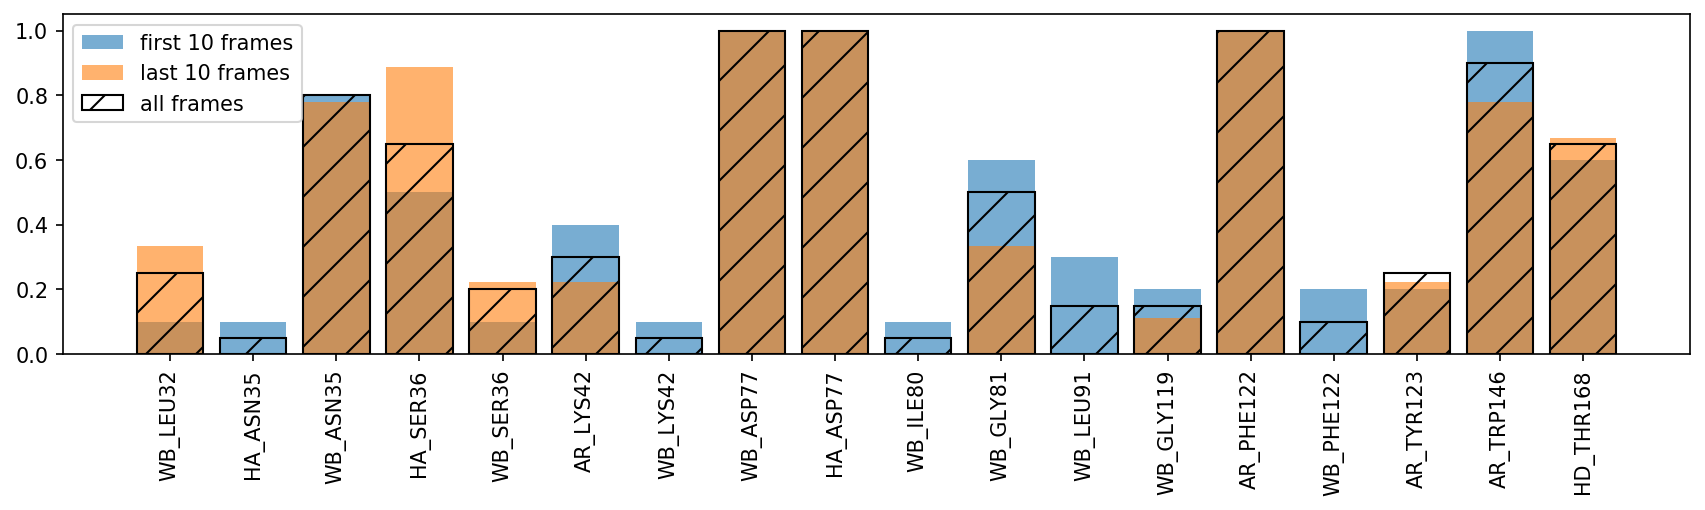

In [12]:

Plot_IF_trajectory(df_prop_complete,ifp_type = np.asarray(['AR','HA','HD','IP','IN',"IO","WB"]),head_tail=10)

#### 2.4 Visualization of protein residues involved in PL interactions
For the last point of this part we are gonna visualize the residues that participate in the IFP.

In [13]:
# obtain string that contains unique residues interacting with water
watr = ''.join([resid+' ' for resid in np.unique(df_WB.sele2_resid.values.astype(str))])

# obtain residues that participate in aromatic interaction
residues = ''.join([str(ifp[6:]+' ') for ifp in df_prop_complete.columns.tolist() 
                    if (ifp[:2] == 'AR')])
print("Showing Residues: ", residues)

# Visualize the Complex

view = nv.NGLWidget()
protein = u_mem.select_atoms('protein or (resname INH WAT)')
w=nv.show_mdanalysis(protein)
w.add_licorice(watr+residues)
w

Showing Residues:  42 122 123 146 


NGLWidget(max_frame=19)

## 3. Generation of IFPs for a PDB file               (HSP90, PDB ID: 2YKI)

Lastlz, We will use the trajectory.py script in order to get the properties of our ligand and another IFP analysis.

### 3.1 IFP calculations

In [14]:
# Define path to input data
ref_pdb = "Data/2YKI/2yki_MOE.pdb"
ligand_pdb_ = "Data/2YKI/ligand_2yki_MOE.pdb"
ligand_mol2 = "Data/2YKI/ligand_2yki_MOE.mol2"

# Load the pdb file into MDAnalysis universe
u = mda.Universe(ref_pdb)

# Define ligand residue name
sel_ligands = 'YKI'

# Get the chemical properties of the ligand with the ligand_properties function from the trajectories script
properties, mol = ligand_properties(ligand_pdb, ligand_mol2)
print(properties)

# IFP analysis, for reference look at 1. or 2.
df_prop,df_HB,df_WB = IFP(u,sel_ligands,properties,WB_analysis=True,RE=False)
df_prop_complete = table_combine(df_HB,df_WB,df_prop,sel_ligands)

# Summary for all interactions
ifp_type = ['HY','AR','WB','HA','HD']
at_type = [[],[],[],[],[]]
for v in df_prop_complete.columns.tolist():
    for i,t in enumerate(ifp_type):
        if v.find(t)>=0:
            at_type[i].append(v)
            
print('\n',10*'--','Contacts found:',10*'--')
print("\nHydrophobic contacts: ",at_type[0])
print("\nAromatic contacts: ",at_type[1])
print("\nWater Bridges: ",at_type[2])
print("\nHydrogen Acceptors: ",at_type[3])
print("\nHydrogen Donors: ",at_type[4])

{'Donor': ['O4', 'C6', 'N8', 'N10', 'C12'], 'Acceptor': ['C2', 'C6', 'N10', 'C19'], 'PosIonizable': ['C9', 'C6', 'C7', 'O4', 'C11'], 'Aromatic': ['O4', 'C7', 'C6', 'C9', 'C11', 'C12', 'H7', 'C31', 'H12', 'H9', 'C1', 'C2', 'N3', 'C11', 'C9', 'C5', 'N10', 'C21', 'C20', 'C18', 'C31', 'H7', 'C13', 'C16', 'C15', 'N14', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'N30'], 'Hydrophobe': ['C5', 'C13', 'N14', 'C15', 'C16', 'C18', 'C20', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'N30', 'C31', 'H12'], 'LumpedHydrophobe': ['C13', 'C16', 'C15', 'N14', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'N30']}
Start HB analysis 09:03:39.984259
Start WB analysis 09:03:40.275094
Start collecting IFPs:  09:03:40.931716
Start building IFP table:  09:03:41.687284
IFP database is ready  09:03:41.689284

 -------------------- Contacts found: --------------------

Hydrophobic contacts:  ['HY_ASN51', 'HY_ALA55', 'HY_MET98', 'HY_LEU107', 'HY_ALA111', 'HY_PHE138', 'HY_THR184']

Aromatic contacts:  ['A

In [15]:
df_prop_complete

,time,WB_GLN23,HY_ASN51,HY_ALA55,HY_MET98,HY_LEU107,HY_ALA111,AR_PHE138,HY_PHE138,AR_TRP162,AR_PHE170,HY_THR184,WAT
0,0,1,1,1,1,1,1,1,1,1,1,1,6


### 3.2 Visualization of PL interactions

In [16]:
view = nv.NGLWidget()
protein = u.select_atoms('all')
w=nv.show_mdanalysis(protein)
residues = "".join([str(ifp[6:] + " ") for ifp in df_prop_complete.columns.tolist()])
print("Showing residues: ", residues)
w.add_licorice(residues)
w

Showing residues:   23 51 55 98 107 111 138 138 162 170 184  


NGLWidget()